In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
input_params = {
    'x_path' : '/ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_MTfilt_rna.csv',
    'y_path' : '/ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_Ylabels.csv',
    'fdr' : 0.1,
    'thresh_fdr': 0.1,
    'spec' : 0.2,
    'y_factor': True,
    'niter' : 500,
    'SLIDE_top_feats': 20,
    'pure_homo' : True,
    'delta' : [0.1],
    'lambda' : [0.5],
    'out_path': '/ix3/djishnu/alw399/SLIDE_py/example_results/slide_py'
    
}

In [4]:
import sys
sys.path.append('src/SLIDE')

In [5]:
from slide import OptimizeSLIDE
slider = OptimizeSLIDE(input_params)


### PARAMETERS ###

x_path: /ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_MTfilt_rna.csv
y_path: /ix/djishnu/Jane/SLIDE_PLM/alok_antigen/data/cd4_INS1_INSIAPP3_Ylabels.csv
fdr: 0.1
thresh_fdr: 0.1
spec: 0.2
y_factor: True
niter: 500
SLIDE_top_feats: 20
pure_homo: True
delta: [0.1]
lambda: [0.5]
out_path: /ix3/djishnu/alw399/SLIDE_py/example_results/slide_py
n_workers: 1

###### DATA ######

227 samples
1061 features
84.6% cases
15.4% controls

##################

Running LOVE with delta=0.1 and lambda=0.5
LOVE found 133 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 133
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [04:25<00:00, 265.42s/it]


Found 1 standalone LF
Finding interacting LF...


Processing subsets: 100%|██████████| 1/1 [05:01<00:00, 301.08s/it]


Found 2 interacting LF

SLIDE complete.

Completed 0.1_0.5

##################

CPU times: user 7min 59s, sys: 2.04 s, total: 8min 1s
Wall time: 10min 20s


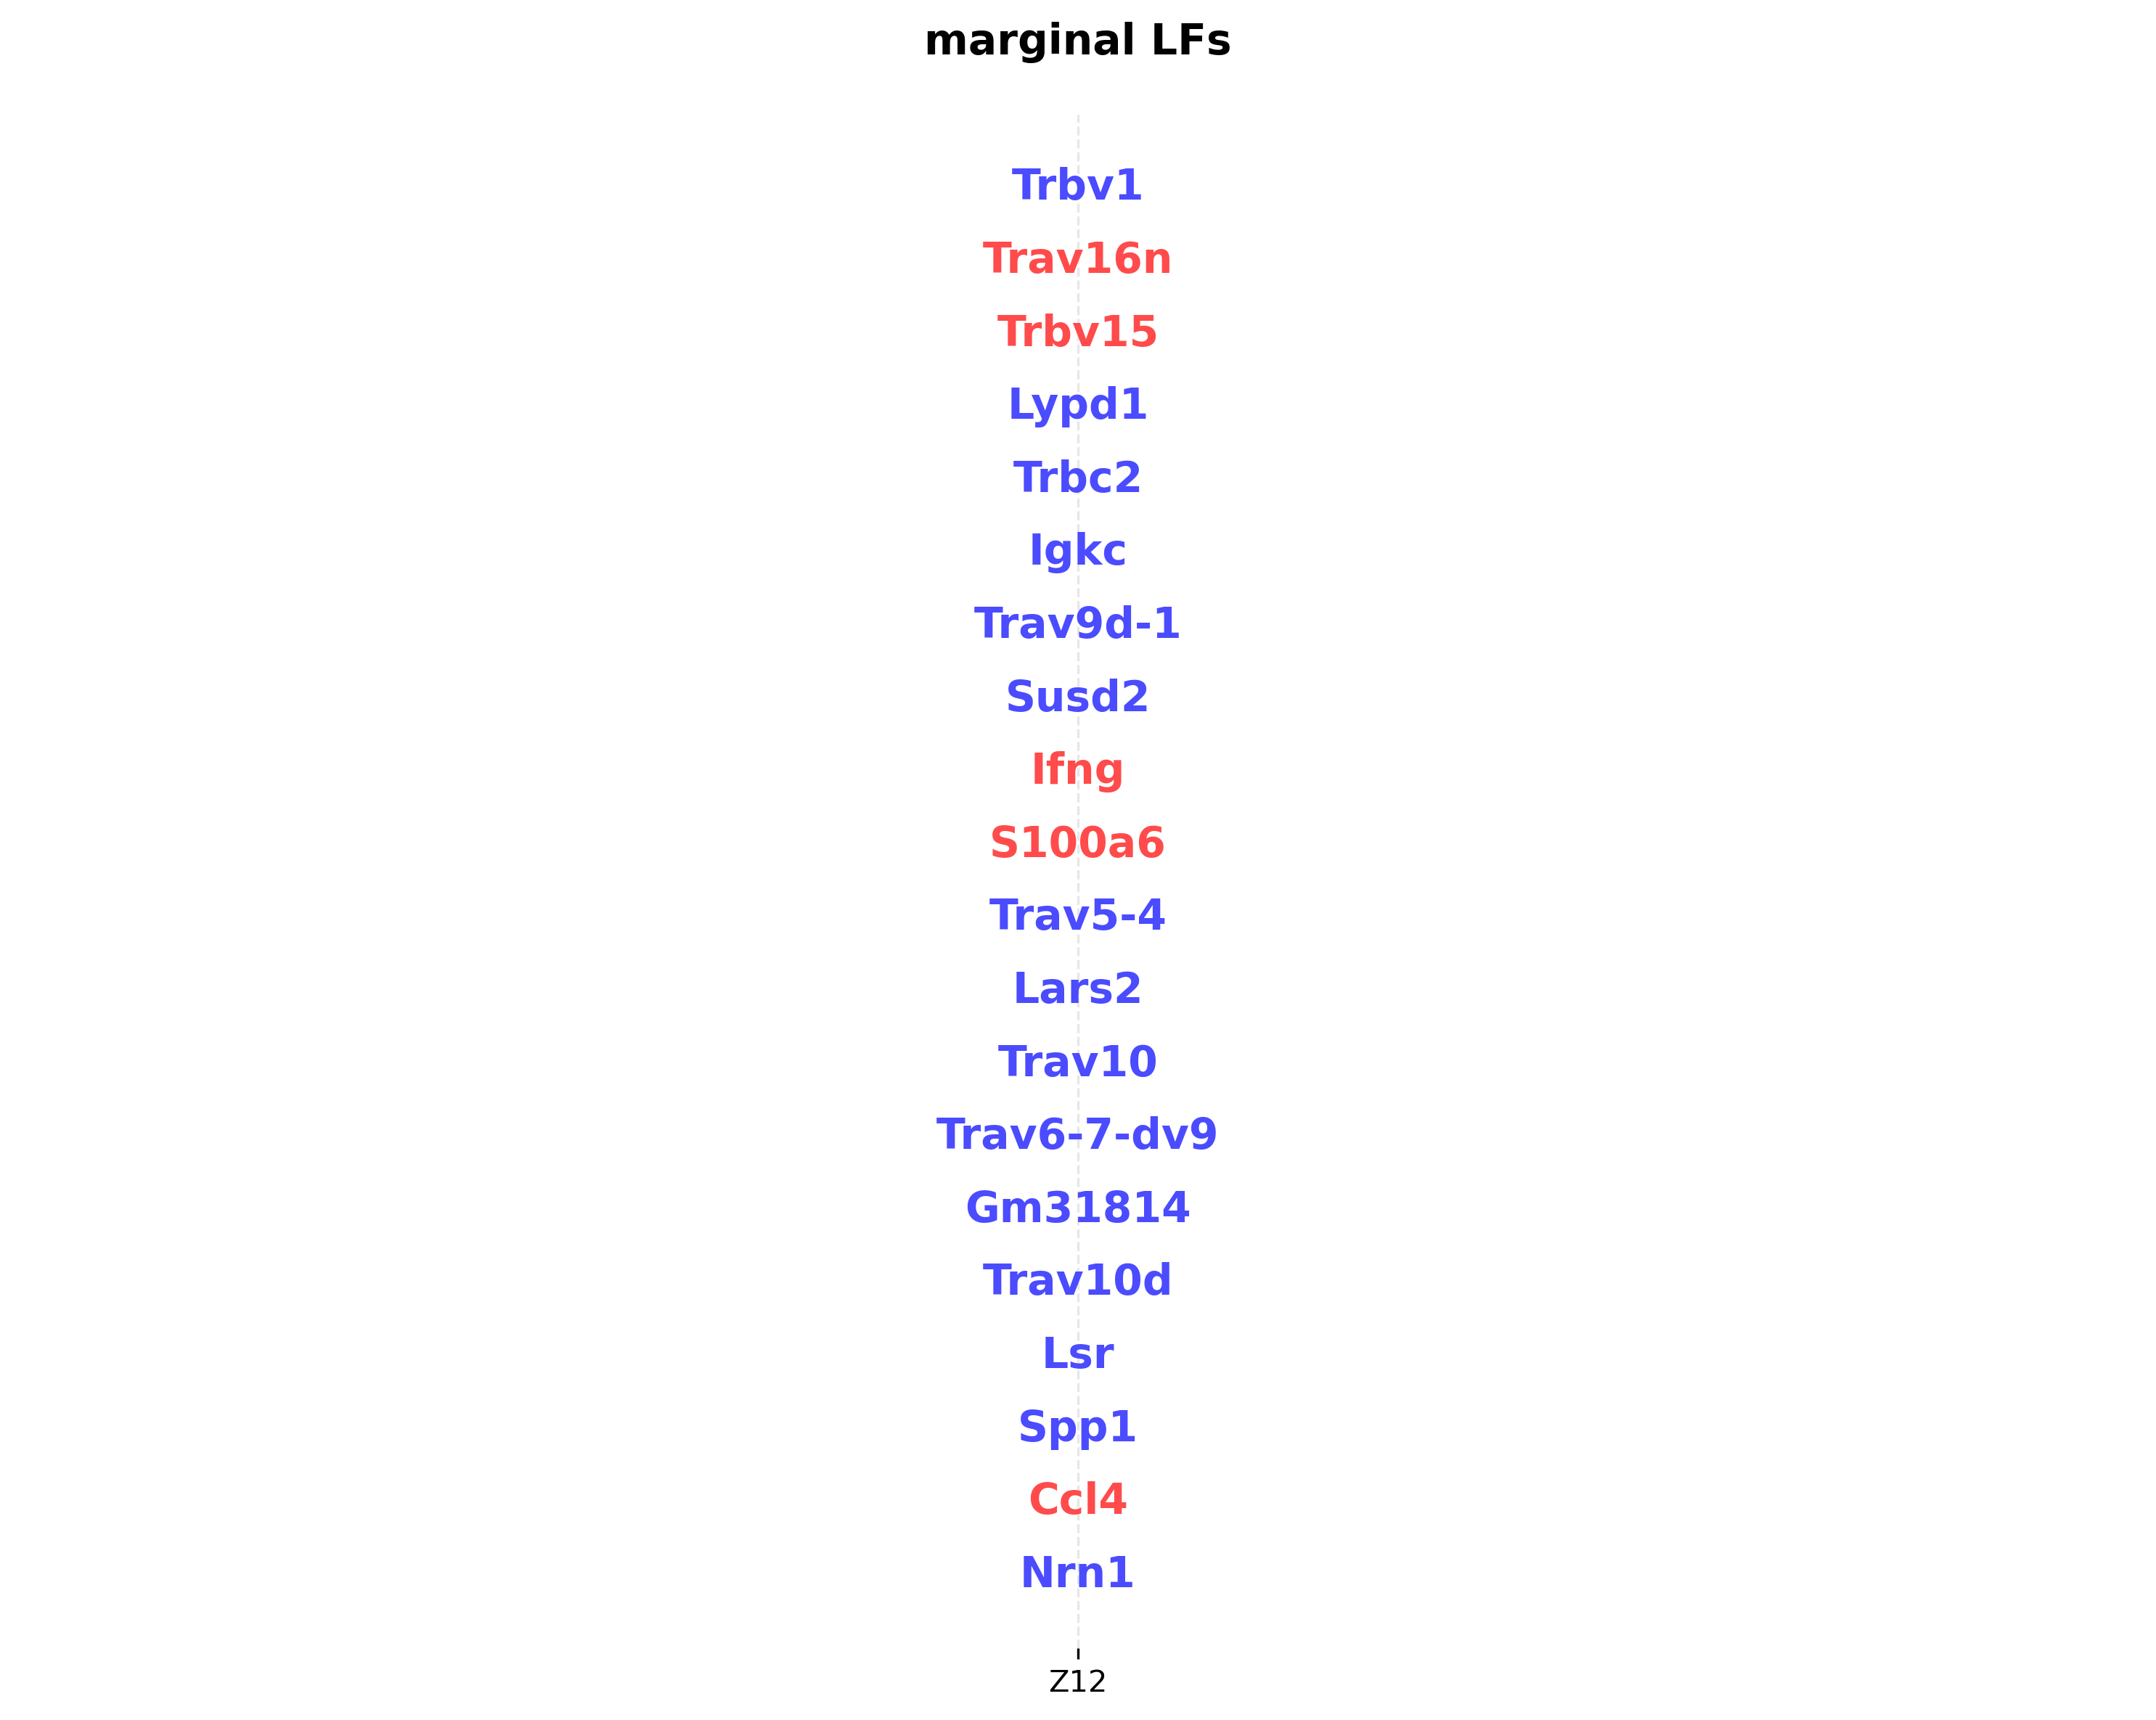

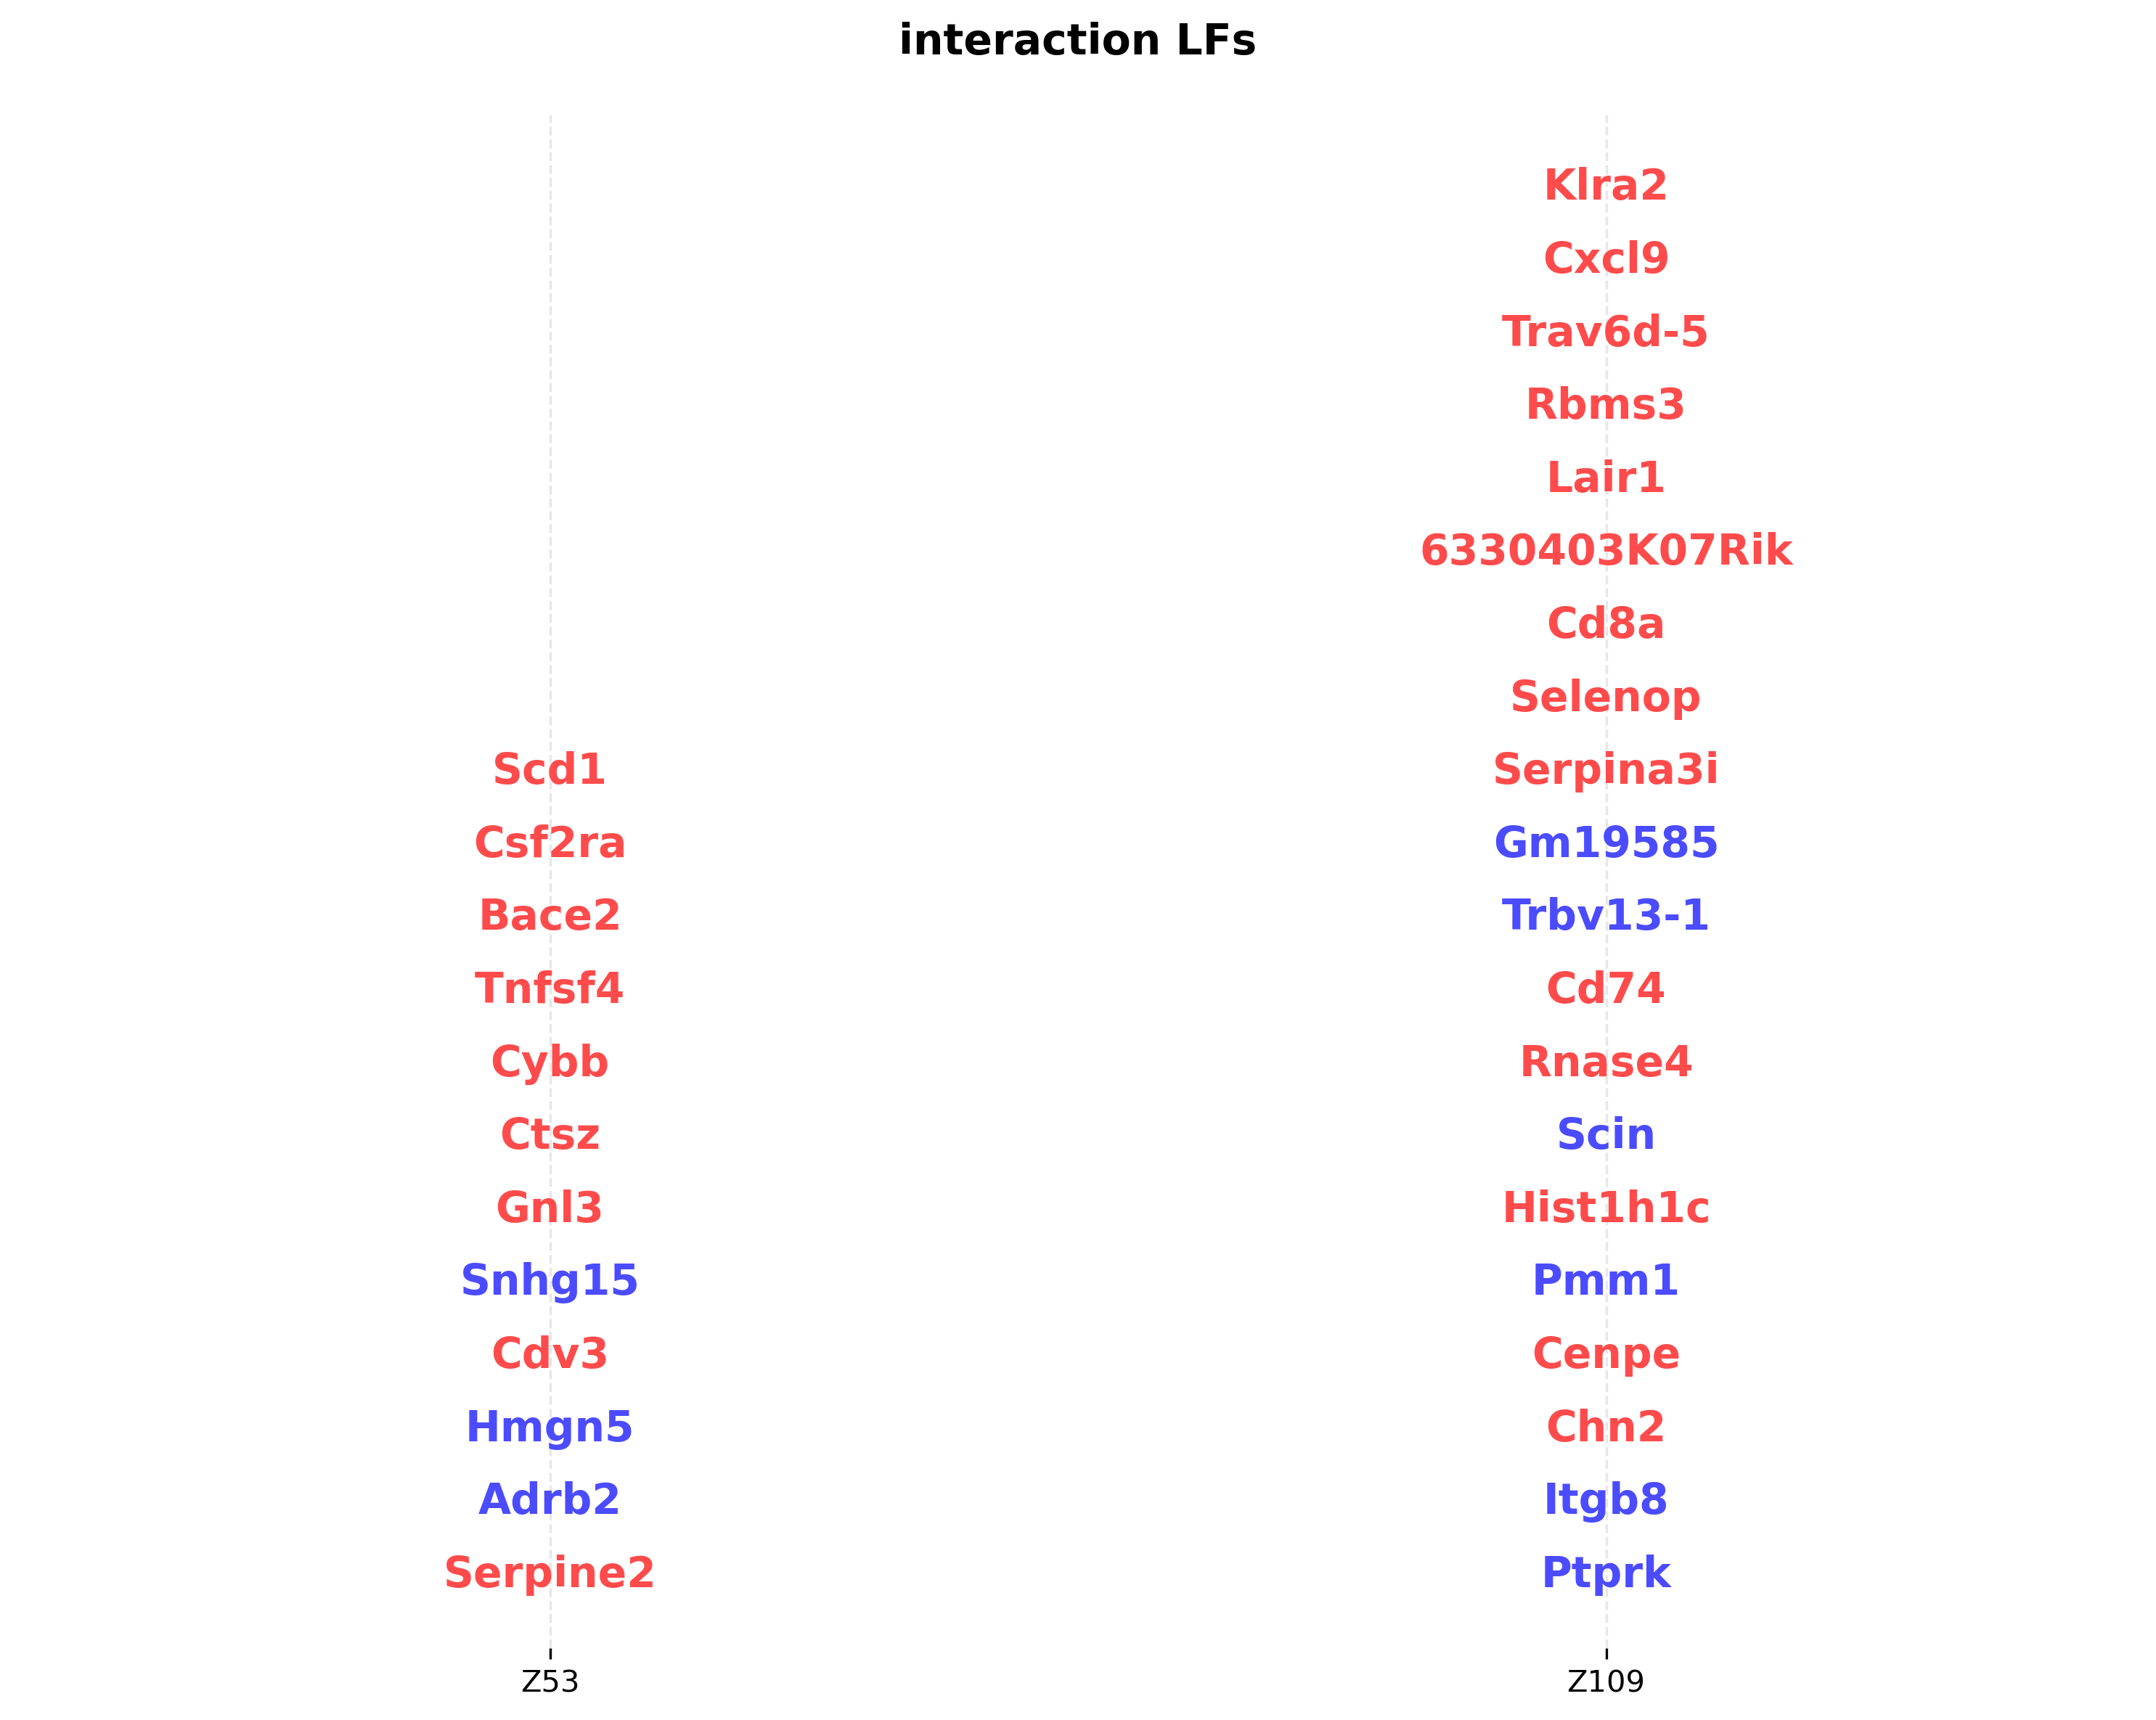

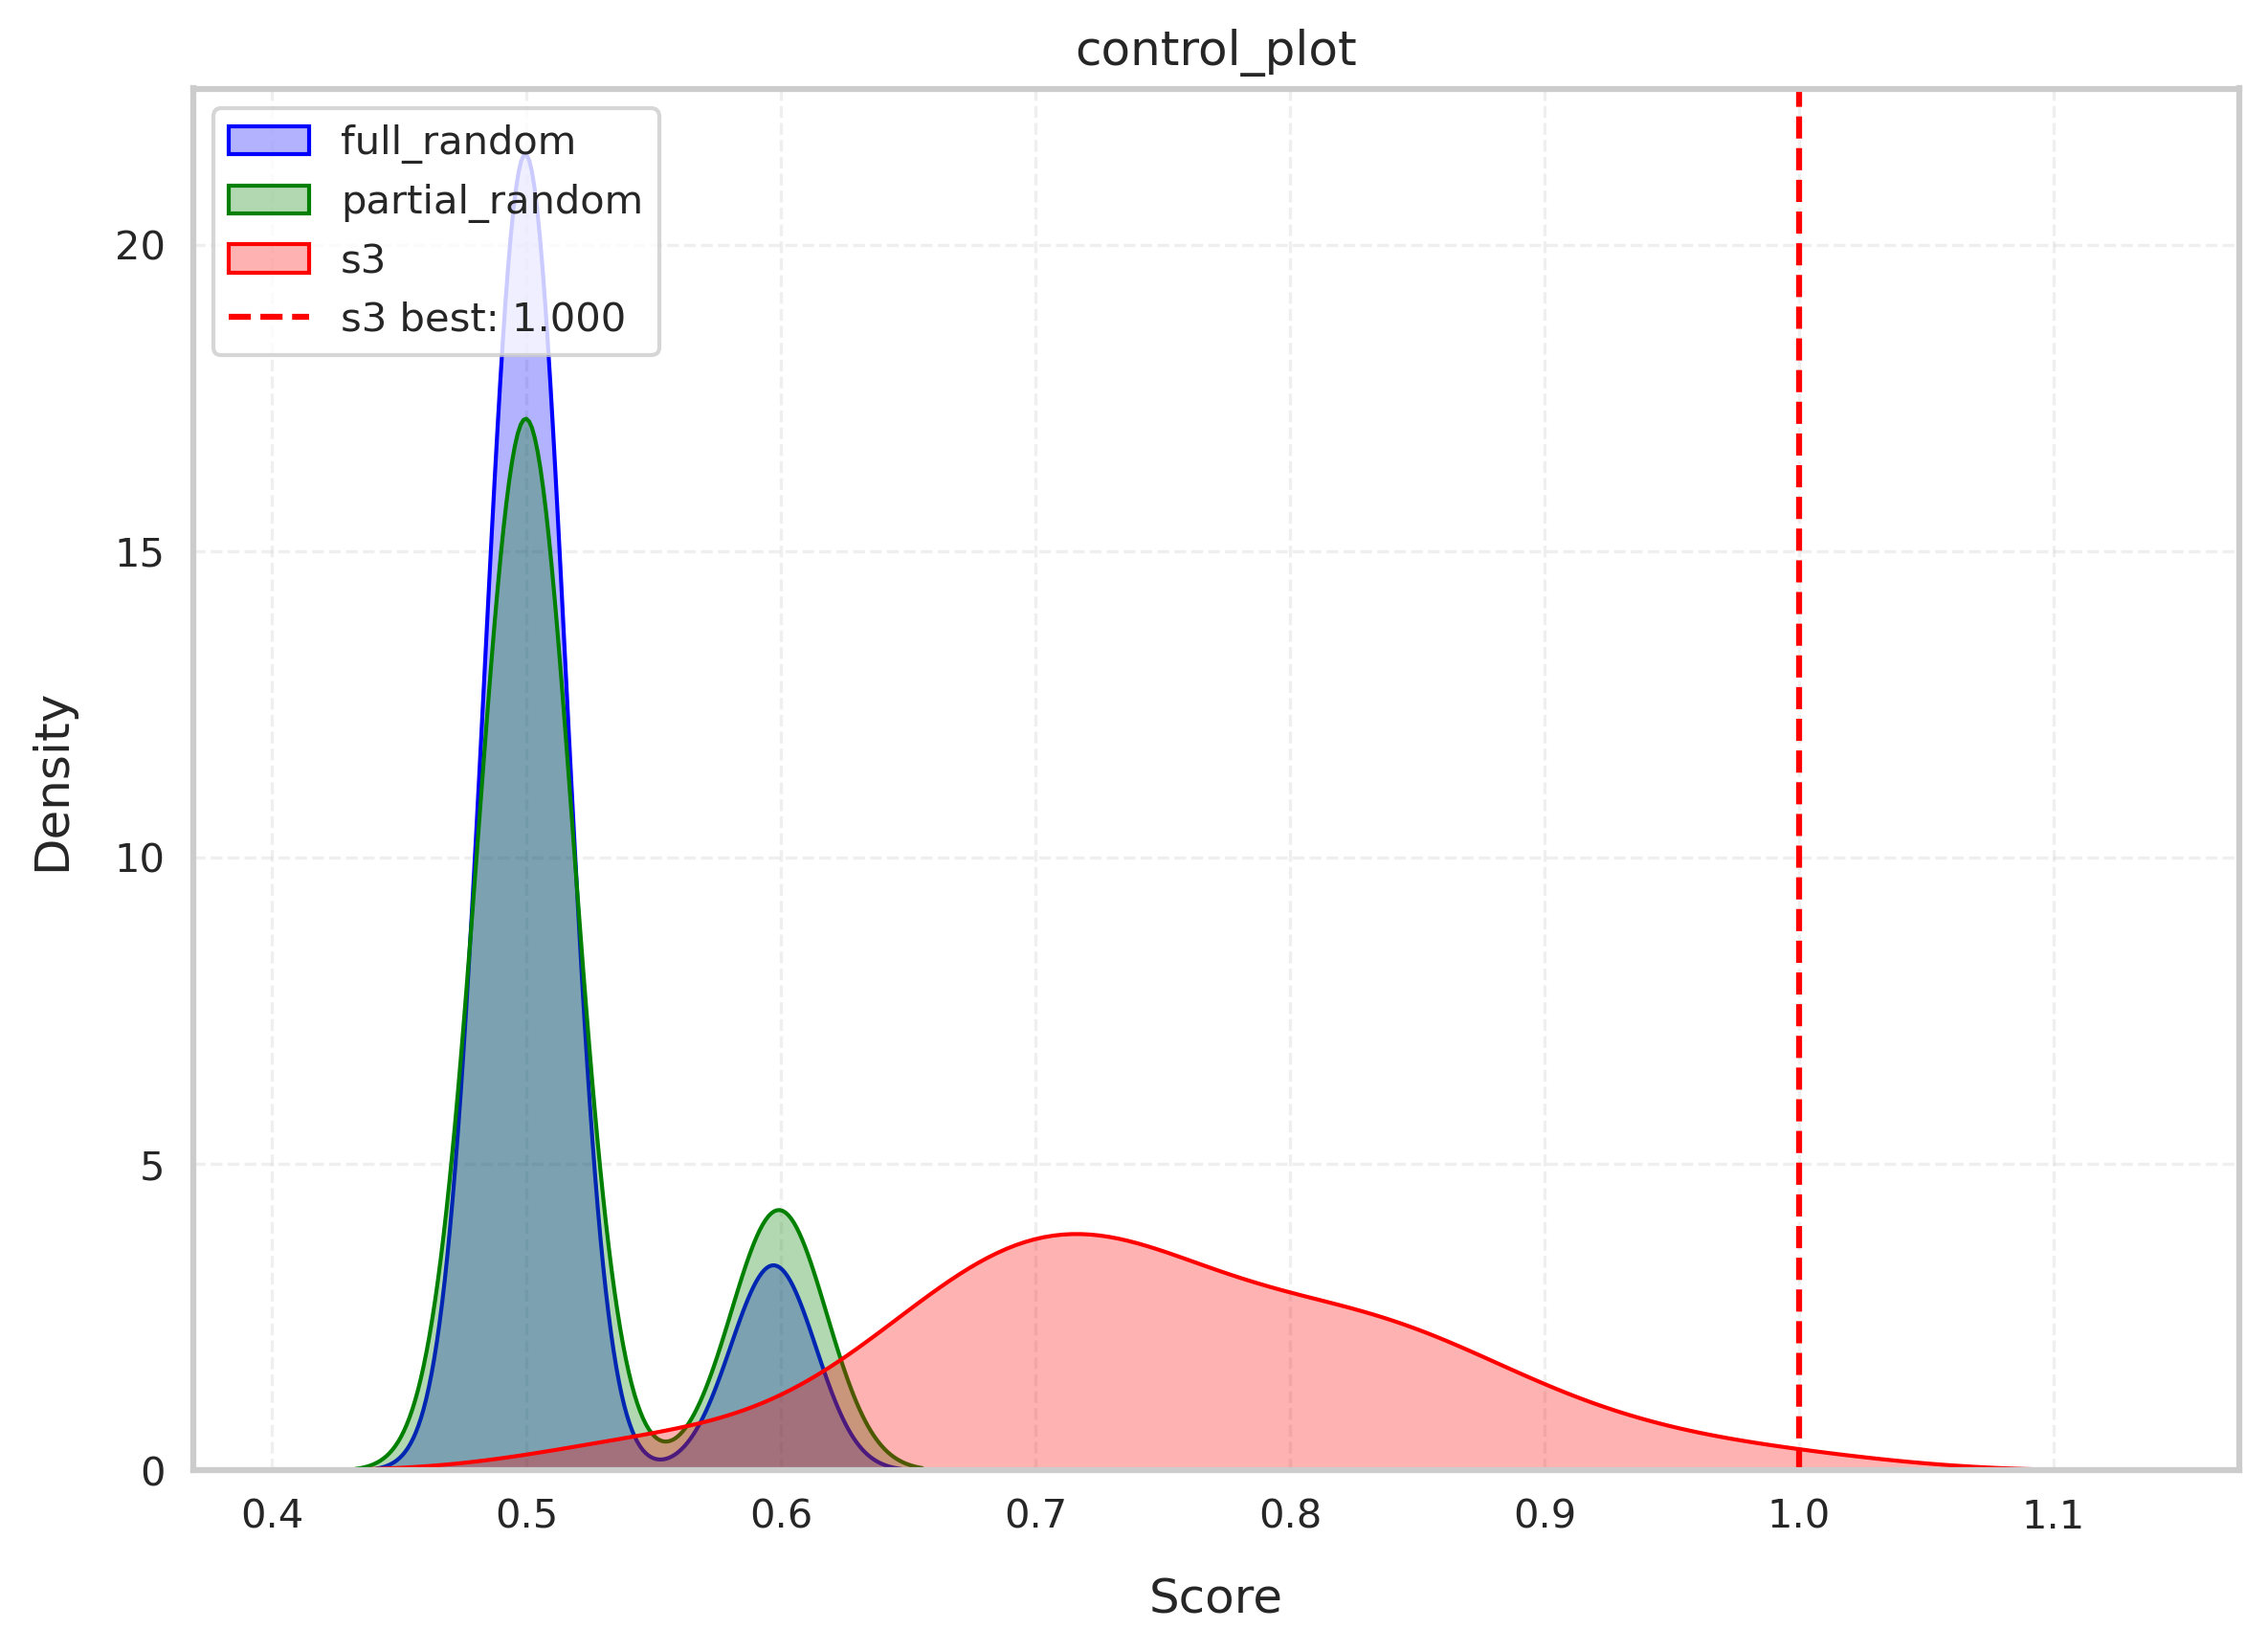

In [6]:
%%time
slider.run_pipeline(verbose=True, n_workers=1)

In [7]:
# slider.create_summary_table(slider.input_params['out_path'])


### Debugging

In [ ]:
out_iter = '/ix3/djishnu/alw399/SLIDE_py/example_results/slide_py/0.1_0.5_out/love_result.pkl'

slider.show_params()
slider.load_love(out_iter)

In [ ]:
n_workers = 1
verbose=True

slider.run_SLIDE(
    latent_factors=slider.latent_factors, 
    niter=slider.input_params['niter'], 
    spec=slider.input_params['spec'], 
    fdr=slider.input_params['fdr'],
    verbose=verbose,
    n_workers=n_workers,
    outpath=out_iter
)

In [ ]:
from knockoffs import Knockoffs

machop = Knockoffs(slider.data['Y'].values, slider.latent_factors.values)
machop 

In [ ]:
result = machop.filter_knockoffs_iterative(machop.z2, machop.y, fdr=0.1, niter=10)
result

In [7]:
delta = 0.1
lbd = 0.5

out_iter = input_params['out_path'] + f'/{delta}_{lbd}_out'

In [8]:
slider.load_love(out_iter + '/love_result.pkl')

In [67]:
slider.sig_LFs = np.loadtxt(out_iter + '/sig_LFs.txt', dtype=str).reshape(-1).tolist()
slider.sig_interacts = np.loadtxt(out_iter + '/sig_interacts.txt', dtype=str).reshape(-1).tolist()

In [ ]:
from knockoffs import Knockoffs

n = slider.latent_factors.shape[0]

slider.interaction_terms = Knockoffs.get_interaction_terms(
    slider.latent_factors[slider.sig_LFs].values, 
    slider.latent_factors[slider.sig_interacts].values
).reshape(n, -1)

slider.interaction_terms.shape

In [ ]:
from plotting import Plotter

sig_LF_genes = {str(lf): slider.get_LF_genes(
    lf=lf, 
    top_feats=20,
    outpath=out_iter) for lf in slider.sig_LFs}
_ = Plotter.plot_latent_factors(sig_LF_genes, loadings=slider.A, outdir=out_iter, title='marginal_LFs')

In [ ]:
sig_interact_genes = {str(lf): slider.get_LF_genes(
    lf=lf, 
    top_feats=20,
    outpath=out_iter) for lf in slider.sig_interacts}
_ = Plotter.plot_latent_factors(sig_interact_genes, loadings=slider.A, outdir=out_iter, title='interaction_LFs')